In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

file_name = "/content/drive/My Drive/FYP_FR_W/Photos2_mdv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from zipfile import ZipFile

file_name = "/content/drive/My Drive/FYP_FR_W/Photos2_test.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [ ]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
from tqdm import tqdm
from model import create_model
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
import tensorflow
from keras.initializers import RandomNormal
from keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import time
import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os.path

import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [ ]:
from keras.models import model_from_json
import cv2
from model import create_model
from Align import AlignDlib
import dlib
import pickle
from PIL import Image
import base64
import io
import keras
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from sklearn import preprocessing

In [ ]:
import tensorflow as tf
import keras

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
print(cv2.__version__)

4.1.2


In [ ]:
print(keras.__version__)

2.4.3


In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [ ]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('/content/Photos2')

In [ ]:
(pd.Series(extension)).value_counts()

.jpg    18
dtype: int64

In [ ]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

metadata = load_metadata('/content/Photos2')

In [ ]:
len(metadata)

18

In [ ]:
names = np.array([m.name for m in metadata])

In [ ]:
np.save('names.npy', names)

In [ ]:
pd.Series(names).value_counts()#[:5]

Suvankar    6
Priya       6
Writam      6
dtype: int64

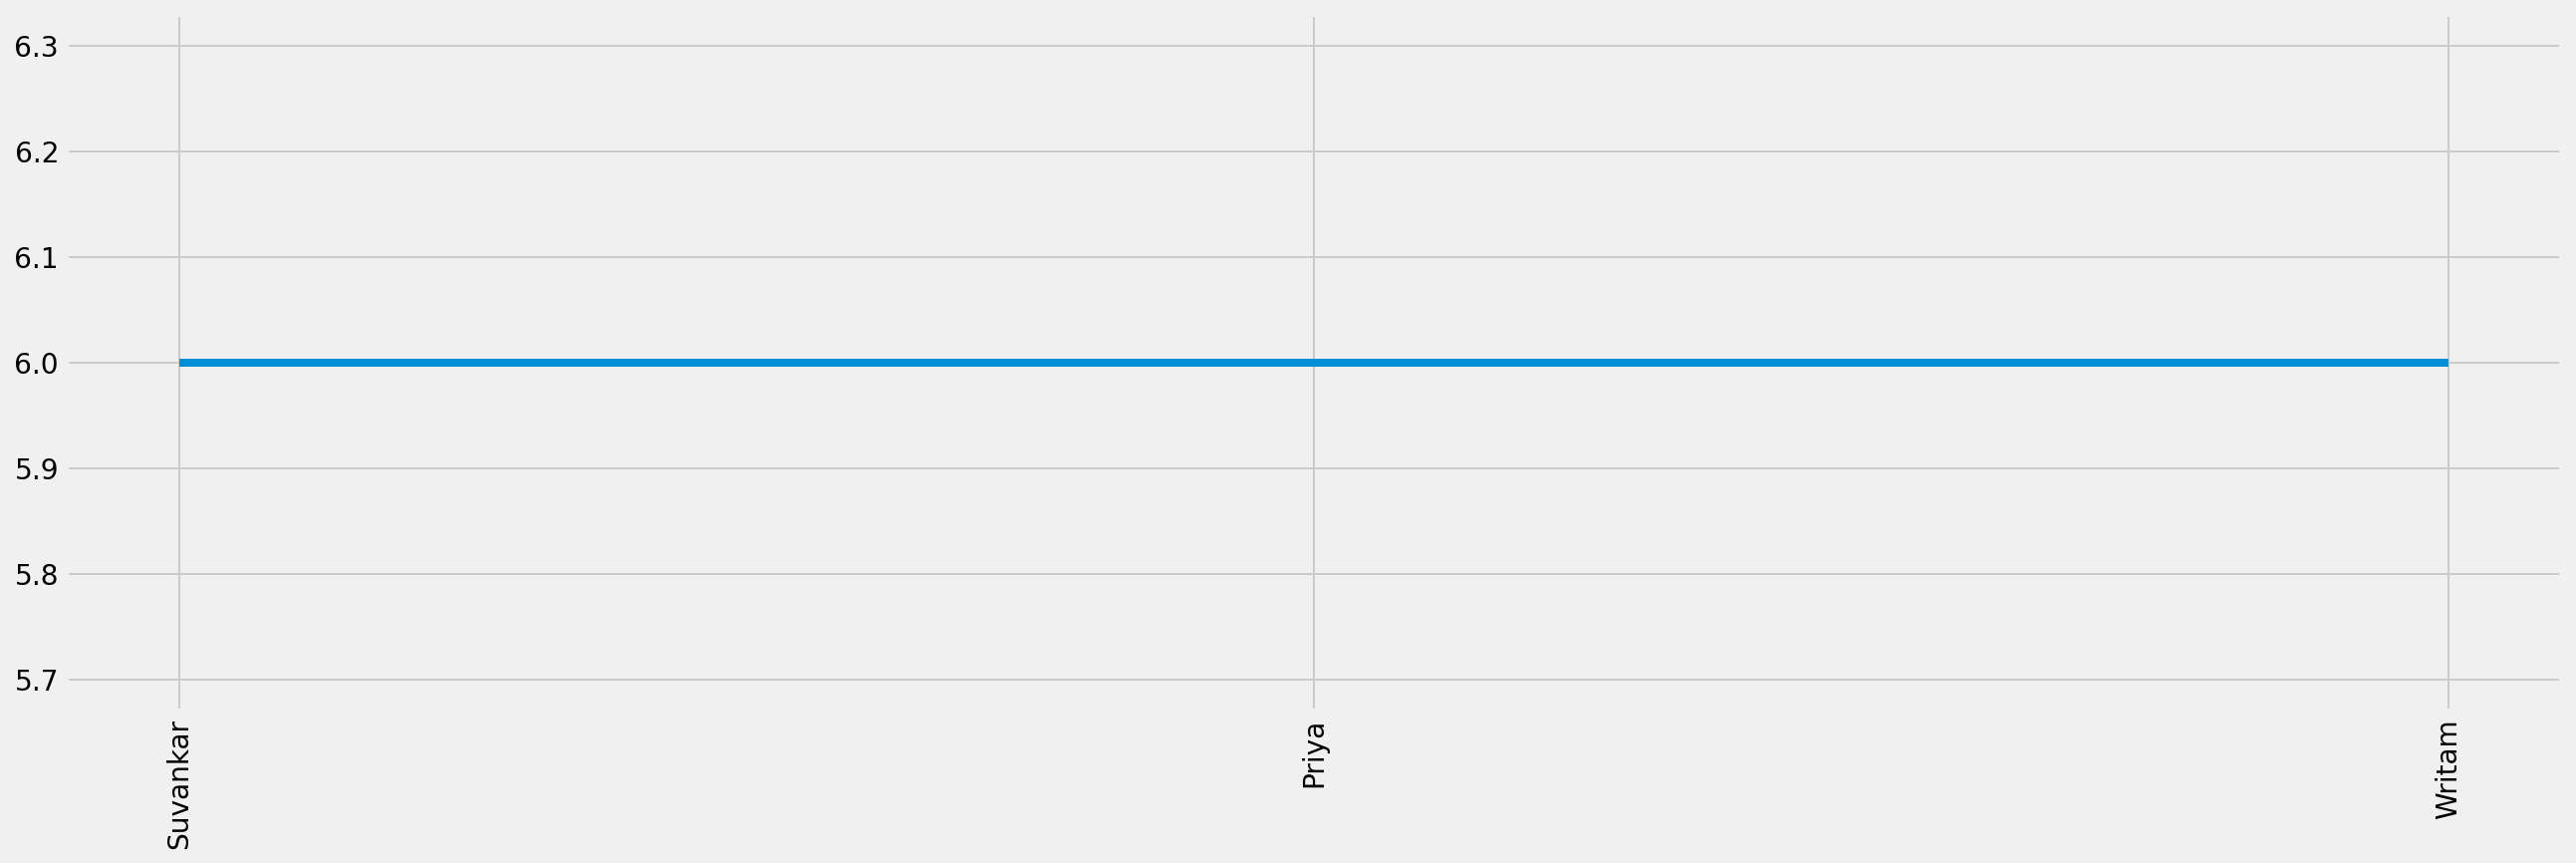

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [ ]:
alignment = AlignDlib('/content/drive/My Drive/FYP_FR_W/landmarks.dat')

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]
  
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img),landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
#Load pretrained Model

model_of = create_model()
model_of.load_weights('/content/drive/My Drive/FYP_FR_W/open_face.h5')

In [ ]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in tqdm(enumerate(metadata)):
    try:
      img = load_image(m.image_path())
      img = align_image(img)
      # scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = model_of.predict(np.expand_dims(img, axis=0))[0]
    except:
      print(i,m)

10it [00:08,  1.03it/s]

9 /content/Photos2/Writam/WM4.jpg


12it [00:10,  1.17s/it]

11 /content/Photos2/Writam/WM3.jpg


18it [00:29,  1.64s/it]


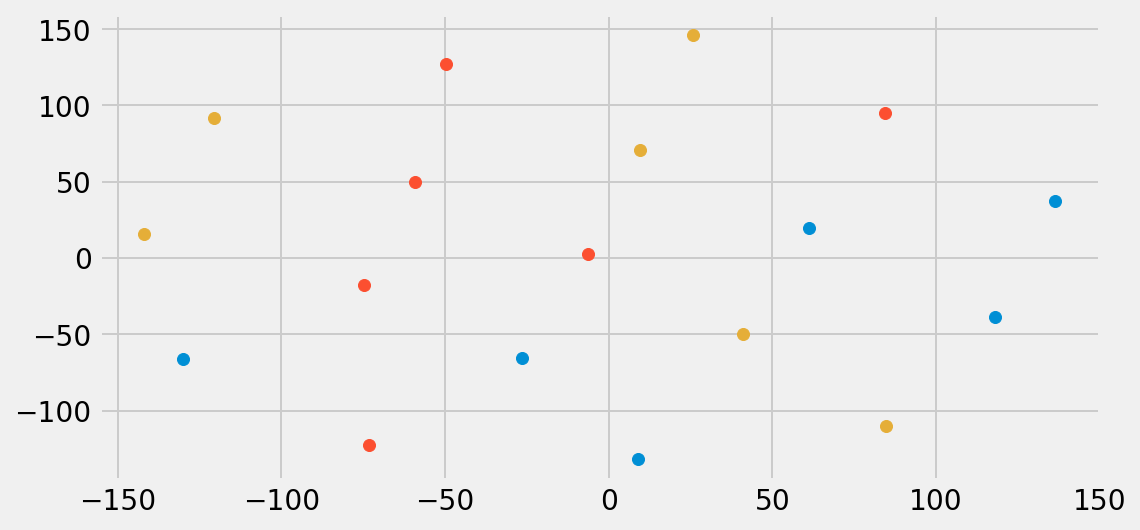

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(names)):
    idx = names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

In [ ]:
print("Input data:",(embedded.shape))
print("Output class:",(names.shape))

Input data: (18, 128)
Output class: (18,)


In [ ]:
df = pd.DataFrame(embedded)
df["output"] = names
#df.to_csv("embedded_.csv",index=False)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,output
0,0.159984,0.039726,-0.054747,0.079513,0.024338,0.168062,0.067892,-0.055884,-0.165992,-0.015796,0.123999,0.063224,0.065749,0.071498,-0.016840,-0.076694,0.105277,0.196870,0.037395,0.056341,0.084056,0.012578,0.017346,0.182813,0.007793,-0.147258,-0.009662,-0.015963,-0.060439,0.183980,-0.146624,-0.059313,-0.024440,0.120552,0.027389,-0.006457,-0.011690,-0.102109,-0.054883,-0.049372,...,0.176034,0.048730,-0.184983,-0.021415,-0.026310,0.008961,-0.030408,-0.049250,0.072060,0.009122,0.021884,0.067684,0.200631,0.070683,0.027103,-0.062812,0.090805,-0.013064,-0.037024,-0.134128,-0.024392,0.049542,-0.006633,0.096379,0.016339,-0.029596,0.003633,0.137354,-0.006268,0.004141,0.074909,0.002444,-0.156466,0.015868,0.003019,0.020744,0.074330,0.111227,-0.047302,Priya
1,0.107786,0.111206,-0.152334,0.102533,-0.047058,0.091159,0.001998,-0.106128,-0.130862,0.048310,0.175313,0.013037,0.064878,0.108307,-0.120851,-0.008784,0.129963,0.182624,0.121036,0.013241,0.147280,-0.139459,0.012871,0.052663,0.094036,-0.031610,0.005007,-0.028583,0.055852,0.223663,-0.102602,0.038243,0.040837,-0.026662,0.008126,-0.053179,-0.066582,0.041571,0.117323,-0.100712,...,0.003391,-0.047988,-0.139460,-0.020080,0.052063,0.078225,-0.127635,-0.012769,0.141060,0.003307,-0.003480,0.070525,0.160642,0.056042,0.102359,-0.035441,0.138200,0.096256,0.016386,0.030692,-0.135282,-0.042496,-0.030832,0.003305,0.027527,0.078864,-0.003232,0.025663,-0.038300,0.122705,0.032046,-0.045012,-0.153273,0.009651,-0.088883,0.053700,0.116908,0.160273,0.041736,Priya
2,0.109632,0.119508,-0.092684,0.037469,0.033703,0.178200,0.017808,-0.058865,-0.043774,0.007727,0.163293,0.115966,-0.006242,-0.057435,-0.109121,-0.036795,0.045937,0.208845,-0.008045,-0.038148,0.118021,0.058383,0.033120,0.129106,0.037651,-0.115863,0.117621,-0.044511,-0.017704,0.181590,-0.106928,-0.158746,0.025421,0.053177,0.027323,-0.089235,-0.040777,-0.078013,0.010183,0.059820,...,0.073838,-0.075505,-0.225078,-0.098170,0.017312,0.080396,-0.092109,-0.070253,0.028219,-0.015268,0.048043,0.021048,0.138680,0.019732,0.070147,-0.009779,0.026110,0.016971,-0.031080,-0.137434,-0.073667,0.050140,-0.031586,0.101009,0.082958,0.010369,0.024096,0.001296,0.018386,0.045427,0.077138,0.019478,-0.090986,-0.039946,-0.046991,0.113220,0.077280,0.100390,0.008366,Priya
3,0.099687,0.067787,-0.117577,0.055776,-0.037496,0.167669,0.025995,0.022889,-0.084006,0.113443,0.212676,0.045903,0.020115,0.049693,-0.022684,-0.049511,0.081283,0.198817,0.073952,-0.050771,0.047878,-0.037172,0.009712,0.116021,0.061087,-0.071542,0.133632,0.004665,-0.007320,0.107038,-0.098422,-0.061649,0.029461,0.063800,-0.066186,-0.021429,-0.064038,-0.092277,0.002794,0.033338,...,0.067610,-0.043046,-0.179969,-0.073661,-0.023534,0.105616,-0.059262,-0.065301,0.029450,0.015815,0.037396,0.010330,0.128336,0.080375,0.031269,0.005298,0.092252,0.006656,-0.076249,-0.094615,-0.135825,-0.013324,0.038286,0.126399,0.018138,0.076391,-0.068090,0.137489,-0.032940,0.152508,0.039468,0.073077,-0.196016,0.022278,-0.013410,0.078528,0.064779,0.138245,0.066492,Priya
4,0.117047,0.072433,-0.029753,0.116631,-0.073322,0.141986,0.055085,0.003925,-0.091267,0.009712,0.170611,0.054911,0.026506,0.023691,-0.050954,-0.138830,0.067136,0.179030,0.019845,-0.002126,0.066899,-0.063639,-0.028056,0.151597,0.036249,-0.140829,0.029623,-0.010625,-0.111936,0.124808,-0.129174,-0.114272,0.010180,0.113181,-0.027888,-0.026218,-0.049986,-0.088448,-0.106893,-0.023035,...,0.127007,-0.032839,-0.218835,0.000825,-0.082177,-0.000091,-0.059113,-0.025665,-0.019839,0.026403,0.030939,0.018248,0.214612,0.083993,0.003332,-0.019550,0.066301,-0.001531,-0.004002,-0.171902,-0.081753,0.015362,-0.016516,0.066204,-0.026385,0.021373,-0.049148,0.118310,-0.055018,0.100967,0.035086,0.010381,-0.130165,-0.026230,0.032696,0

In [ ]:
from sklearn.preprocessing import LabelEncoder as le

names_encode = LabelEncoder().fit(names)
Y = names_encode.transform(names)

In [ ]:
# save
np.save('names_encode.npy', names_encode.classes_)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(names)

LabelEncoder()

In [ ]:
Y = le.transform(names)

In [ ]:
le.inverse_transform(Y)

array(['Suvankar', 'Suvankar', 'Suvankar', 'Suvankar', 'Suvankar',
       'Suvankar', 'Writam', 'Writam', 'Writam', 'Writam', 'Writam',
       'Writam', 'Priya', 'Priya', 'Priya', 'Priya', 'Priya', 'Priya'],
      dtype='<U8')

In [ ]:
len(set(names))

3

In [ ]:
y = np.zeros((embedded.shape[0],len(set(Y))),dtype=int)
y.shape

(18, 3)

In [ ]:
for i,name in enumerate(names):
  ind = Y[i]
  y[i][ind]=1

In [ ]:
#train_idx = np.arange(embedded.shape[0]) 
train_idx = np.arange(embedded.shape[0]) % 4 != 0
test_idx = np.arange(embedded.shape[0]) % 4 == 0

print(np.sum(train_idx))
print(np.sum(test_idx))

13
5


In [ ]:
X_train = embedded[train_idx]
y_train = y[train_idx]

X_val = embedded[test_idx]
y_val = y[test_idx]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(13, 128)
(13, 3)


In [ ]:
output_dim = y_train.shape[1]
input_dim = X_train.shape[1]

batch_size = 4
nb_epoch = 100

In [ ]:
model_clf = Sequential()

'''        
model_clf.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model_clf.add(BatchNormalization())
#model_clf.add(Dropout(0.2))
'''
model_clf.add(Dense(256, activation='relu',input_shape=(input_dim,)))
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.2))

model_clf.add(Dense(128, activation='relu'))
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.2))
    
model_clf.add(Dense(64, activation='relu'))
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.2))

model_clf.add(Dense(output_dim, activation='softmax'))

In [ ]:
'''
model_clf= Sequential()

model_clf.add(Dense(25, activation='relu', input_shape=(input_dim,), kernel_initializer=keras.initializers.he_normal(seed=None)))
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))

model_clf.add(Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))

model_clf.add(Dense(10, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))

model_clf.add(Dense(10, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))

model_clf.add(Dense(output_dim,activation='softmax'))
'''

In [ ]:
model_clf.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)               

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    #monitor='val_loss',
    mode='max',
    #mode='min',
    save_best_only=True)

In [ ]:
# all photos in training data
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_clf.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=(X_val,y_val),callbacks=[model_checkpoint_callback])
#history = model_clf.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=(X_val,y_val))

Epoch 1/100
4/4 [==============================] - 0s 60ms/step - loss: 1.4710 - accuracy: 0.2308 - val_loss: 1.0904 - val_accuracy: 0.2000
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1038 - accuracy: 0.3846 - val_loss: 1.0832 - val_accuracy: 0.6000
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0011 - accuracy: 0.6154 - val_loss: 1.0738 - val_accuracy: 0.4000
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.4523 - accuracy: 0.6923 - val_loss: 1.0612 - val_accuracy: 0.4000
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.2752 - accuracy: 0.9231 - val_loss: 1.0518 - val_accuracy: 0.4000
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2442 - accuracy: 0.9231 - val_loss: 1.0387 - val_accuracy: 0.4000
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.4189 - accuracy: 0.8462 - val_loss: 1.0275 - val_accuracy: 0.6000
Epoch 8/100
4/4 [========

In [ ]:
#all in training
history = model_clf.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,callbacks=[model_checkpoint_callback])

Epoch 1/10
5/5 [==============================] - 0s 6ms/step - loss: 2.0796 - accuracy: 0.1667
Epoch 2/10
5/5 [==============================] - 0s 6ms/step - loss: 1.4897 - accuracy: 0.4444
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 1.4100 - accuracy: 0.3889
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 1.6687 - accuracy: 0.2778
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 1.5911 - accuracy: 0.3889
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 1.5462 - accuracy: 0.2222
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 1.5690 - accuracy: 0.3333
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 1.1987 - accuracy: 0.3889
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 1.1242 - accuracy: 0.5000
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 1.8401 - accuracy: 0.1667


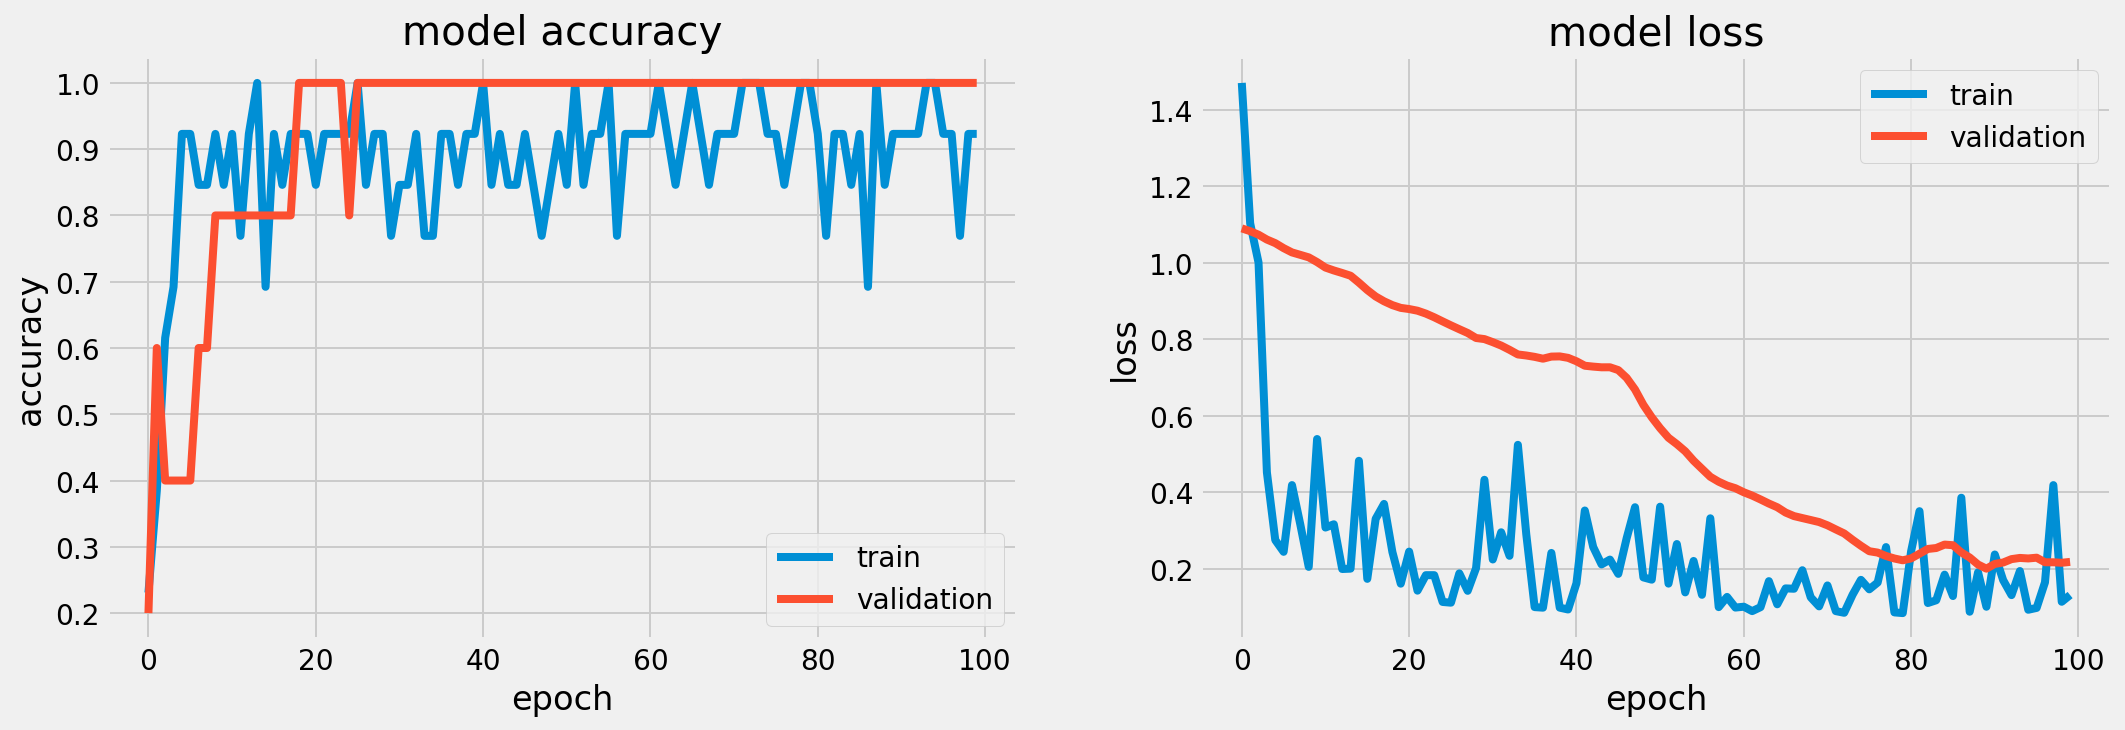

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [ ]:
# serialize model to JSON
model_json = model_clf.to_json()
with open("/content/drive/My Drive/FYP_FR/W_FYP_FR_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_clf.save_weights("/content/drive/My Drive/FYP_FR/W_FYP_FR_weights.h5")

print("Saved model to disk")

Saved model to disk


#Predict Faces

---------------------------------------------------------------------------------

In [ ]:
path = "/content/Cricket_test/Pandya-Rahul.jpeg"

In [ ]:
img = load_image(path)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
faces = alignment.getAllFaceBoundingBoxes(img)
faces

rectangles[[(459, 47) (614, 202)], [(118, 77) (304, 263)]]

In [ ]:
img.shape

(167, 301, 3)

In [ ]:
for i in range(len(faces)):
  face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  face_aligned = (face_aligned / 255.).astype(np.float32)
  embedding = model_of.predict(np.expand_dims(face_aligned, axis=0))
  print(embedding.shape)
  pred = model_clf.predict(embedding)
  ind = np.argsort(pred[0])
  print(ind[::-1][:5])
  print("Prediction: ",le.inverse_transform([ind[::-1][0]])[0])
  print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
  print()

------------------------------------------------------------------------------------------

In [ ]:
def predict_face(path):
  img = load_image(path)
  #print("Original Query Image")
  #plt.imshow(img)
  #plt.grid(b=None)
  faces = alignment.getAllFaceBoundingBoxes(img)
  print(faces)
  for i in range(len(faces)):
    face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    face_aligned = (face_aligned / 255.).astype(np.float32)
    embedding = model_of.predict(np.expand_dims(face_aligned, axis=0))
    pred = model_clf.predict([[embedding]])
    ind = np.argsort(pred[0])
    print(ind[::-1][:5])
    if(pred[0][ind[::-1][0]]*100>70):
      print("Prediction: ",le.inverse_transform([ind[::-1][0]])[0])
      print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
      print()
    else:
      print("Prediction: Others")
      print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
      print()

In [ ]:
path1 = '/content/Photos2_test/WM1.jpg'

Original Query Image


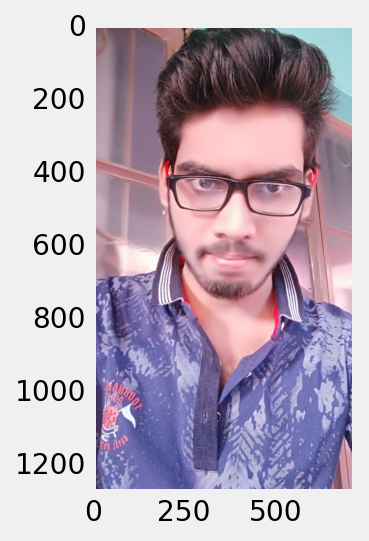

In [ ]:
img = load_image(path1)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path1)

rectangles[[(142, 348) (605, 811)]]
[2 1 0]
Prediction:  Writam
Prediction Probability:  74.25714135169983 %



In [ ]:
path2 = '/content/Photos2_test/WM4.jpg'

Original Query Image


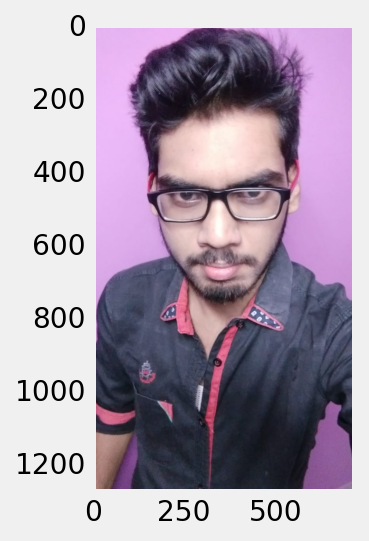

In [ ]:
img = load_image(path2)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path2)

rectangles[[(161, 376) (546, 761)]]
[2 1 0]
Prediction:  Writam
Prediction Probability:  88.36913704872131 %



In [ ]:
path3 = '/content/Photos2_test/PJ1.jpg'

Original Query Image


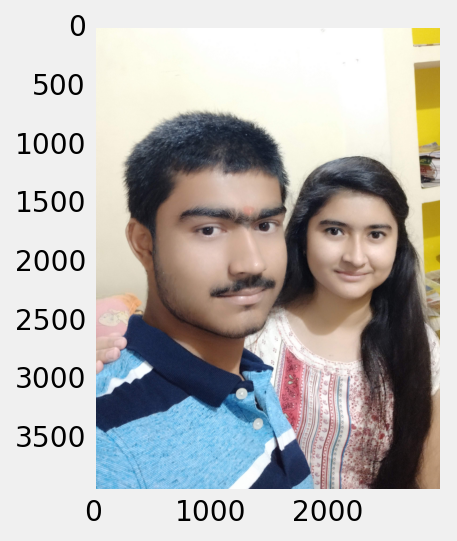

In [ ]:
img = load_image(path3)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path3)

rectangles[[(1845, 1579) (2644, 2378)], [(613, 1380) (1763, 2530)]]
[0 2 1]
Prediction:  Priya
Prediction Probability:  95.94568610191345 %

[1 0 2]
Prediction: Others
Prediction Probability:  61.73086762428284 %



In [ ]:
path4 = '/content/Photos2_test/PJ2.jpg'

Original Query Image


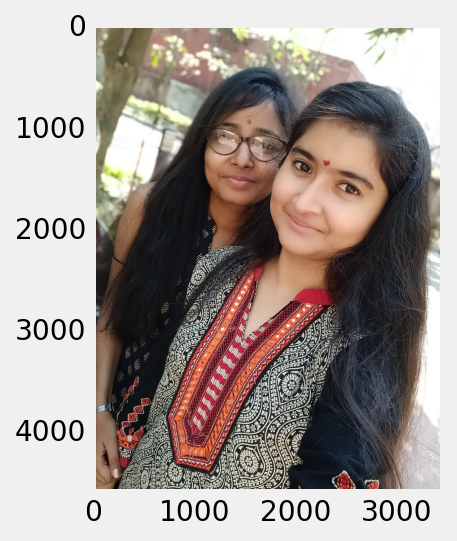

In [ ]:
img = load_image(path4)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path4)

rectangles[[(1635, 1125) (2785, 2275)], [(1135, 958) (1934, 1757)]]
[0 2 1]
Prediction:  Priya
Prediction Probability:  96.03176712989807 %

[0 1 2]
Prediction: Others
Prediction Probability:  46.00340127944946 %



In [ ]:
path5 = '/content/Photos2_test/SB1.jpg'

Original Query Image


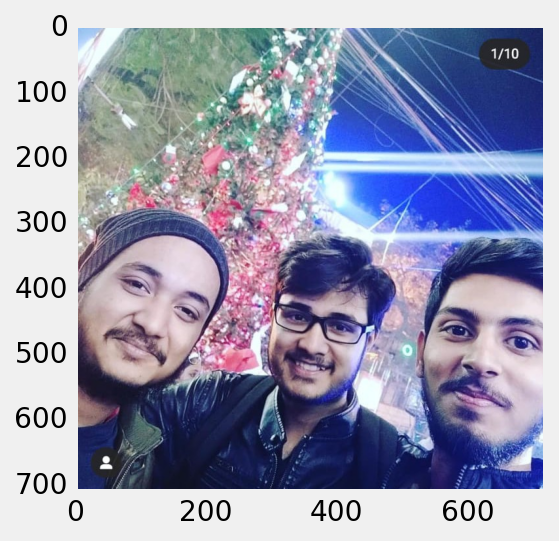

In [ ]:
img = load_image(path5)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path5)

rectangles[[(15, 366) (201, 552)], [(513, 415) (736, 638)], [(287, 408) (442, 563)]]
[1 0 2]
Prediction:  Suvankar
Prediction Probability:  96.20597958564758 %

[1 2 0]
Prediction: Others
Prediction Probability:  59.491556882858276 %

[0 1 2]
Prediction: Others
Prediction Probability:  44.54851448535919 %



In [ ]:
path6 = '/content/Photos2_test/SB2.jpg'

Original Query Image


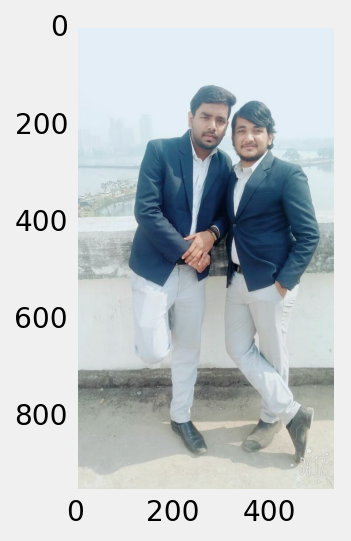

In [ ]:
img = load_image(path6)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [ ]:
predict_face(path6)

rectangles[[(320, 196) (395, 271)], [(245, 171) (320, 246)]]
[1 0 2]
Prediction:  Suvankar
Prediction Probability:  90.87842106819153 %

[2 1 0]
Prediction: Others
Prediction Probability:  67.96264052391052 %



In [ ]:
path7 = '/content/Photos2_test/WM2.jpg'

In [ ]:
predict_face(path7)

rectangles[[(407, 345) (593, 531)], [(598, 134) (919, 455)]]
[1 0 2]
Prediction: Others
Prediction Probability:  43.750667572021484 %

[2 1 0]
Prediction:  Writam
Prediction Probability:  83.40870141983032 %



In [ ]:
path8 = '/content/Photos2_test/WM3.jpg'

In [ ]:
predict_face(path8)

rectangles[[(414, 390) (637, 613)], [(646, 260) (914, 528)]]
[1 0 2]
Prediction: Others
Prediction Probability:  62.954968214035034 %

[2 1 0]
Prediction:  Writam
Prediction Probability:  79.86969947814941 %



# Test Function

In [ ]:
def get_model():
    global model_clf
    json_file = open('/content/drive/MyDrive/FYP_FR_W/W_FYP_FR_model_1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_clf = model_from_json(loaded_model_json)
    model_clf.load_weights("/content/drive/MyDrive/FYP_FR_W/W_FYP_FR_weights_1.h5")
    model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Loaded NN model from disk")

In [ ]:
def get_openface_model():
	global model_of
	model_of = create_model()
	model_of.load_weights('/content/drive/My Drive/FYP_FR_W/open_face.h5')
	#global graph
	#graph = tf.get_default_graph()
	print('Loaded openface model')

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

In [ ]:
def load_names_label_encoder():
	global names_encode
	names_encode = preprocessing.LabelEncoder()
	names_encode.classes_ = np.load('/content/names_encode.npy')

In [ ]:
def predict_face(path):
  img = load_image(path)
  faces = alignment.getAllFaceBoundingBoxes(img)
  print(faces)
  for i in range(len(faces)):
    face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    face_aligned = (face_aligned / 255.).astype(np.float32)
    embedding = model_of.predict(np.expand_dims(face_aligned, axis=0))
    pred = model_clf.predict([[embedding]])
    ind = np.argsort(pred[0])
    print(ind[::-1][:5])
    if(pred[0][ind[::-1][0]]*100>70):
      print("Prediction: ",le.inverse_transform([ind[::-1][0]])[0])
      print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
      print()
    else:
      print("Prediction: Others")
      print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
      print()

In [ ]:
get_model()

Loaded NN model from disk


In [ ]:
get_openface_model()

Loaded openface model


In [ ]:
alignment = AlignDlib('/content/drive/My Drive/FYP_FR_W/landmarks.dat')

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
names = np.load('/content/names.npy')

In [ ]:
le.fit(names)

LabelEncoder()

In [ ]:
path3 = '/content/Photos2_test/PJ1.jpg'

In [ ]:
predict_face(path3)

rectangles[[(1845, 1579) (2644, 2378)], [(613, 1380) (1763, 2530)]]
[0 2 1]
Prediction:  Priya
Prediction Probability:  95.94568610191345 %

[1 0 2]
Prediction: Others
Prediction Probability:  61.73089146614075 %

